In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight

# Data import

In [4]:
ctl = pd.read_csv('Data/smad_timecourse_singlecells_ctl.csv')
times = ctl['time']
ctl = ctl.drop(columns='time')

In [5]:
tgfb_low = pd.read_csv('Data/smad_timecourse_singlecells_tgfb_low.csv').drop(columns='time')
print(f"tgfb size: {tgfb_low.values.T.shape}")
gdf11_high = pd.read_csv('Data/smad_timecourse_singlecells_gdf11_high.csv').drop(columns='time')
print(f"gdf11 size: {gdf11_high.values.T.shape}")

tgfb size: (1230, 288)
gdf11 size: (2692, 288)


In [6]:
x_total = np.concatenate([ctl.values.T,tgfb_low.values.T,gdf11_high.values.T],axis=0).reshape([-1,ctl.shape[0],1])
y_total = np.concatenate([np.ones(ctl.shape[1]),2*np.ones(tgfb_low.shape[1]),3*np.ones(gdf11_high.shape[1])])

In [7]:
x_train,x_test,y_train,y_test = train_test_split(x_total,y_total,test_size=0.25)
print('x_train,y_train:',x_train.shape,y_train.shape)

x_train,y_train: (6300, 288, 1) (6300,)


In [8]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train.reshape([-1,1]))
y_train_oh,y_test_oh = one_hot_encoder.transform(y_train.reshape([-1,1])),one_hot_encoder.transform(y_test.reshape([-1,1]))

print('y_train_oh:',y_train_oh.shape)

y_train_oh: (6300, 3)


# Model building & Training

In [9]:
import tensorflow as tf
import tensorflow.keras as kr

In [10]:
def plotFitting(optim):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(optim.history['loss'])
    plt.plot(optim.history['val_loss'])
    plt.ylabel('loss (Categorial crossentropy)')
    plt.xlabel('epochs')
    plt.ylim(0)

    plt.subplot(1,2,2)
    plt.plot(optim.history['categorical_accuracy'])
    plt.plot(optim.history['val_categorical_accuracy'])
    plt.ylabel('Accuracy (Categorial)')
    plt.xlabel('epochs')
    plt.ylim(0)

    plt.tight_layout()

In [18]:
n_kernels = 32
kernel_width = 10
strides = 3

inp = kr.Input((288,1))

conv1 = kr.layers.Conv1D(n_kernels, kernel_width, activation="relu", strides=strides)(inp)
drop1 = kr.layers.Dropout(0.2)(conv1)
dense1 = kr.layers.Dense(n_kernels, activation="relu")(drop1)

conv2 = kr.layers.Conv1D(n_kernels/2, kernel_width, activation="relu", strides=strides)(dense1)
drop2 = kr.layers.Dropout(0.2)(conv2)
dense2 = kr.layers.Dense(n_kernels, activation="relu")(drop2)

hidden1 = kr.layers.Flatten()(conv2)
hidden2 = kr.layers.Dense(27,activation='relu')(hidden1)
hidden3 = kr.layers.Dense(9,activation='relu')(hidden2)
out = kr.layers.Dense(3,activation='softmax')(hidden3)

model = kr.Model(inputs=inp,outputs=out)
optimizer = kr.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss=kr.losses.categorical_crossentropy,
    metrics=[kr.metrics.categorical_accuracy]
)
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 288, 1)]          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 93, 32)            352       
_________________________________________________________________
dropout_2 (Dropout)          (None, 93, 32)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 93, 32)            1056      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 28, 16)            5136      
_________________________________________________________________
flatten_6 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 27)              

In [19]:
with tf.device('/GPU:0'):
    optim = model.fit(x=x_train,y=y_train_oh,batch_size=256,epochs=600,
                  validation_split=0.25,shuffle=False)

Epoch 1/600
19/19 [==============================] - 1s 32ms/step - loss: 1.0884 - categorical_accuracy: 0.4912 - val_loss: 1.0790 - val_categorical_accuracy: 0.5352
Epoch 2/600
19/19 [==============================] - 0s 16ms/step - loss: 1.0575 - categorical_accuracy: 0.5365 - val_loss: 1.0374 - val_categorical_accuracy: 0.5352
Epoch 3/600
19/19 [==============================] - 0s 16ms/step - loss: 1.0224 - categorical_accuracy: 0.5367 - val_loss: 1.0162 - val_categorical_accuracy: 0.5352
Epoch 4/600
19/19 [==============================] - 0s 16ms/step - loss: 1.0076 - categorical_accuracy: 0.5367 - val_loss: 1.0025 - val_categorical_accuracy: 0.5352
Epoch 5/600
19/19 [==============================] - 0s 16ms/step - loss: 0.9936 - categorical_accuracy: 0.5367 - val_loss: 0.9898 - val_categorical_accuracy: 0.5352
Epoch 6/600
19/19 [==============================] - 0s 16ms/step - loss: 0.9835 - categorical_accuracy: 0.5367 - val_loss: 0.9806 - val_categorical_accuracy: 0.5352
Epoc

19/19 [==============================] - ETA: 0s - loss: 0.6986 - categorical_accuracy: 0.67 - 0s 16ms/step - loss: 0.6975 - categorical_accuracy: 0.6741 - val_loss: 0.6695 - val_categorical_accuracy: 0.6775
Epoch 50/600
19/19 [==============================] - 0s 17ms/step - loss: 0.6948 - categorical_accuracy: 0.6703 - val_loss: 0.6672 - val_categorical_accuracy: 0.6857
Epoch 51/600
19/19 [==============================] - 0s 16ms/step - loss: 0.6924 - categorical_accuracy: 0.6671 - val_loss: 0.6646 - val_categorical_accuracy: 0.6863
Epoch 52/600
19/19 [==============================] - 0s 16ms/step - loss: 0.6942 - categorical_accuracy: 0.6665 - val_loss: 0.6644 - val_categorical_accuracy: 0.6781
Epoch 53/600
19/19 [==============================] - 0s 16ms/step - loss: 0.6910 - categorical_accuracy: 0.6775 - val_loss: 0.6641 - val_categorical_accuracy: 0.6838
Epoch 54/600
19/19 [==============================] - 0s 17ms/step - loss: 0.6883 - categorical_accuracy: 0.6758 - val_loss:

Epoch 98/600
19/19 [==============================] - 0s 17ms/step - loss: 0.6367 - categorical_accuracy: 0.7043 - val_loss: 0.6153 - val_categorical_accuracy: 0.7213
Epoch 99/600
19/19 [==============================] - 0s 16ms/step - loss: 0.6379 - categorical_accuracy: 0.7043 - val_loss: 0.6139 - val_categorical_accuracy: 0.7206
Epoch 100/600
19/19 [==============================] - 0s 17ms/step - loss: 0.6330 - categorical_accuracy: 0.7096 - val_loss: 0.6134 - val_categorical_accuracy: 0.7225
Epoch 101/600
19/19 [==============================] - 0s 16ms/step - loss: 0.6338 - categorical_accuracy: 0.7048 - val_loss: 0.6137 - val_categorical_accuracy: 0.7225
Epoch 102/600
19/19 [==============================] - 0s 18ms/step - loss: 0.6330 - categorical_accuracy: 0.7115 - val_loss: 0.6116 - val_categorical_accuracy: 0.7225
Epoch 103/600
19/19 [==============================] - 0s 16ms/step - loss: 0.6322 - categorical_accuracy: 0.7092 - val_loss: 0.6104 - val_categorical_accuracy: 0

19/19 [==============================] - 0s 16ms/step - loss: 0.5781 - categorical_accuracy: 0.7376 - val_loss: 0.5641 - val_categorical_accuracy: 0.7460
Epoch 147/600
19/19 [==============================] - 0s 16ms/step - loss: 0.5765 - categorical_accuracy: 0.7418 - val_loss: 0.5636 - val_categorical_accuracy: 0.7498
Epoch 148/600
19/19 [==============================] - 0s 17ms/step - loss: 0.5760 - categorical_accuracy: 0.7420 - val_loss: 0.5619 - val_categorical_accuracy: 0.7479
Epoch 149/600
19/19 [==============================] - 0s 17ms/step - loss: 0.5735 - categorical_accuracy: 0.7399 - val_loss: 0.5585 - val_categorical_accuracy: 0.7556
Epoch 150/600
19/19 [==============================] - 0s 16ms/step - loss: 0.5719 - categorical_accuracy: 0.7378 - val_loss: 0.5606 - val_categorical_accuracy: 0.7492
Epoch 151/600
19/19 [==============================] - 0s 17ms/step - loss: 0.5672 - categorical_accuracy: 0.7350 - val_loss: 0.5604 - val_categorical_accuracy: 0.7467
Epoch 

19/19 [==============================] - 0s 16ms/step - loss: 0.4951 - categorical_accuracy: 0.7835 - val_loss: 0.4992 - val_categorical_accuracy: 0.7860
Epoch 195/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4976 - categorical_accuracy: 0.7774 - val_loss: 0.4977 - val_categorical_accuracy: 0.7829
Epoch 196/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4894 - categorical_accuracy: 0.7862 - val_loss: 0.4968 - val_categorical_accuracy: 0.7854
Epoch 197/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4908 - categorical_accuracy: 0.7810 - val_loss: 0.4952 - val_categorical_accuracy: 0.7873
Epoch 198/600
19/19 [==============================] - 0s 17ms/step - loss: 0.4863 - categorical_accuracy: 0.7854 - val_loss: 0.4943 - val_categorical_accuracy: 0.7873
Epoch 199/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4863 - categorical_accuracy: 0.7862 - val_loss: 0.4927 - val_categorical_accuracy: 0.7860
Epoch 

Epoch 243/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4289 - categorical_accuracy: 0.8201 - val_loss: 0.4508 - val_categorical_accuracy: 0.8070
Epoch 244/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4290 - categorical_accuracy: 0.8150 - val_loss: 0.4487 - val_categorical_accuracy: 0.8076
Epoch 245/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4242 - categorical_accuracy: 0.8176 - val_loss: 0.4508 - val_categorical_accuracy: 0.8070
Epoch 246/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4251 - categorical_accuracy: 0.8195 - val_loss: 0.4491 - val_categorical_accuracy: 0.8044
Epoch 247/600
19/19 [==============================] - 0s 17ms/step - loss: 0.4212 - categorical_accuracy: 0.8229 - val_loss: 0.4479 - val_categorical_accuracy: 0.8057
Epoch 248/600
19/19 [==============================] - 0s 16ms/step - loss: 0.4184 - categorical_accuracy: 0.8256 - val_loss: 0.4490 - val_categorical_accuracy:

Epoch 292/600
19/19 [==============================] - 0s 16ms/step - loss: 0.3731 - categorical_accuracy: 0.8474 - val_loss: 0.4197 - val_categorical_accuracy: 0.8279
Epoch 293/600
19/19 [==============================] - 0s 16ms/step - loss: 0.3785 - categorical_accuracy: 0.8476 - val_loss: 0.4193 - val_categorical_accuracy: 0.8216
Epoch 294/600
19/19 [==============================] - 0s 15ms/step - loss: 0.3753 - categorical_accuracy: 0.8468 - val_loss: 0.4192 - val_categorical_accuracy: 0.8248
Epoch 295/600
19/19 [==============================] - 0s 16ms/step - loss: 0.3803 - categorical_accuracy: 0.8440 - val_loss: 0.4184 - val_categorical_accuracy: 0.8254
Epoch 296/600
19/19 [==============================] - 0s 16ms/step - loss: 0.3752 - categorical_accuracy: 0.8428 - val_loss: 0.4179 - val_categorical_accuracy: 0.8241
Epoch 297/600
19/19 [==============================] - 0s 17ms/step - loss: 0.3747 - categorical_accuracy: 0.8463 - val_loss: 0.4184 - val_categorical_accuracy:

Epoch 341/600
19/19 [==============================] - 0s 16ms/step - loss: 0.3362 - categorical_accuracy: 0.8650 - val_loss: 0.3970 - val_categorical_accuracy: 0.8311
Epoch 342/600
19/19 [==============================] - 0s 16ms/step - loss: 0.3330 - categorical_accuracy: 0.8637 - val_loss: 0.3947 - val_categorical_accuracy: 0.8292
Epoch 343/600
19/19 [==============================] - 0s 16ms/step - loss: 0.3338 - categorical_accuracy: 0.8631 - val_loss: 0.3958 - val_categorical_accuracy: 0.8337
Epoch 344/600
19/19 [==============================] - 0s 17ms/step - loss: 0.3315 - categorical_accuracy: 0.8618 - val_loss: 0.3949 - val_categorical_accuracy: 0.8330
Epoch 345/600
19/19 [==============================] - 0s 17ms/step - loss: 0.3299 - categorical_accuracy: 0.8671 - val_loss: 0.3959 - val_categorical_accuracy: 0.8311
Epoch 346/600
19/19 [==============================] - 0s 17ms/step - loss: 0.3312 - categorical_accuracy: 0.8673 - val_loss: 0.3943 - val_categorical_accuracy:

Epoch 390/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2964 - categorical_accuracy: 0.8840 - val_loss: 0.3751 - val_categorical_accuracy: 0.8470
Epoch 391/600
19/19 [==============================] - 0s 17ms/step - loss: 0.2978 - categorical_accuracy: 0.8819 - val_loss: 0.3740 - val_categorical_accuracy: 0.8419
Epoch 392/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2928 - categorical_accuracy: 0.8857 - val_loss: 0.3772 - val_categorical_accuracy: 0.8457
Epoch 393/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2934 - categorical_accuracy: 0.8840 - val_loss: 0.3745 - val_categorical_accuracy: 0.8451
Epoch 394/600
19/19 [==============================] - 0s 17ms/step - loss: 0.2912 - categorical_accuracy: 0.8844 - val_loss: 0.3741 - val_categorical_accuracy: 0.8463
Epoch 395/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2935 - categorical_accuracy: 0.8838 - val_loss: 0.3740 - val_categorical_accuracy:

Epoch 439/600
19/19 [==============================] - 0s 17ms/step - loss: 0.2585 - categorical_accuracy: 0.9046 - val_loss: 0.3599 - val_categorical_accuracy: 0.8527
Epoch 440/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2608 - categorical_accuracy: 0.8961 - val_loss: 0.3565 - val_categorical_accuracy: 0.8527
Epoch 441/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2608 - categorical_accuracy: 0.8997 - val_loss: 0.3573 - val_categorical_accuracy: 0.8533
Epoch 442/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2612 - categorical_accuracy: 0.8961 - val_loss: 0.3548 - val_categorical_accuracy: 0.8565
Epoch 443/600
19/19 [==============================] - 0s 17ms/step - loss: 0.2586 - categorical_accuracy: 0.9014 - val_loss: 0.3554 - val_categorical_accuracy: 0.8533
Epoch 444/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2585 - categorical_accuracy: 0.9012 - val_loss: 0.3596 - val_categorical_accuracy:

19/19 [==============================] - 0s 17ms/step - loss: 0.2263 - categorical_accuracy: 0.9156 - val_loss: 0.3427 - val_categorical_accuracy: 0.8597
Epoch 488/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2273 - categorical_accuracy: 0.9120 - val_loss: 0.3406 - val_categorical_accuracy: 0.8629
Epoch 489/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2256 - categorical_accuracy: 0.9107 - val_loss: 0.3433 - val_categorical_accuracy: 0.8622
Epoch 490/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2269 - categorical_accuracy: 0.9130 - val_loss: 0.3478 - val_categorical_accuracy: 0.8667
Epoch 491/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2323 - categorical_accuracy: 0.9096 - val_loss: 0.3456 - val_categorical_accuracy: 0.8698
Epoch 492/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2273 - categorical_accuracy: 0.9120 - val_loss: 0.3425 - val_categorical_accuracy: 0.8648
Epoch 

Epoch 536/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2060 - categorical_accuracy: 0.9211 - val_loss: 0.3304 - val_categorical_accuracy: 0.8724
Epoch 537/600
19/19 [==============================] - 0s 16ms/step - loss: 0.1971 - categorical_accuracy: 0.9259 - val_loss: 0.3399 - val_categorical_accuracy: 0.8775
Epoch 538/600
19/19 [==============================] - 0s 16ms/step - loss: 0.2005 - categorical_accuracy: 0.9236 - val_loss: 0.3310 - val_categorical_accuracy: 0.8743
Epoch 539/600
19/19 [==============================] - 0s 16ms/step - loss: 0.1988 - categorical_accuracy: 0.9274 - val_loss: 0.3315 - val_categorical_accuracy: 0.8705
Epoch 540/600
19/19 [==============================] - 0s 15ms/step - loss: 0.1940 - categorical_accuracy: 0.9297 - val_loss: 0.3323 - val_categorical_accuracy: 0.8743
Epoch 541/600
19/19 [==============================] - 0s 16ms/step - loss: 0.1983 - categorical_accuracy: 0.9225 - val_loss: 0.3330 - val_categorical_accuracy:

Epoch 585/600
19/19 [==============================] - 0s 17ms/step - loss: 0.1736 - categorical_accuracy: 0.9378 - val_loss: 0.3207 - val_categorical_accuracy: 0.8794
Epoch 586/600
19/19 [==============================] - 0s 17ms/step - loss: 0.1717 - categorical_accuracy: 0.9340 - val_loss: 0.3230 - val_categorical_accuracy: 0.8832
Epoch 587/600
19/19 [==============================] - 0s 16ms/step - loss: 0.1774 - categorical_accuracy: 0.9354 - val_loss: 0.3222 - val_categorical_accuracy: 0.8825
Epoch 588/600
19/19 [==============================] - 0s 16ms/step - loss: 0.1726 - categorical_accuracy: 0.9367 - val_loss: 0.3205 - val_categorical_accuracy: 0.8794
Epoch 589/600
19/19 [==============================] - 0s 16ms/step - loss: 0.1722 - categorical_accuracy: 0.9359 - val_loss: 0.3219 - val_categorical_accuracy: 0.8825
Epoch 590/600
19/19 [==============================] - 0s 17ms/step - loss: 0.1735 - categorical_accuracy: 0.9346 - val_loss: 0.3199 - val_categorical_accuracy:

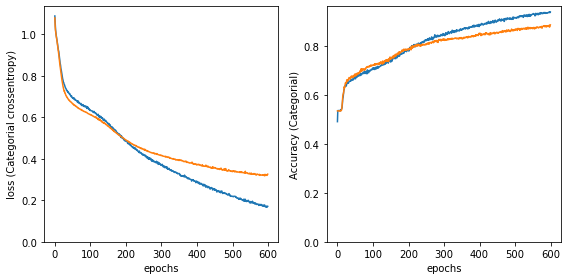

In [20]:
plotFitting(optim)

# GradCAM

In [228]:
class GradCAM:

    def __init__(self,model,layer):
        self.grad_model = kr.models.Model([model.inputs], [model.layers[layer].output, model.output])

    def getHeatmap(self,input_item,pred_index=None):
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = self.grad_model(input_item)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0,1))
        heatmap = tf.squeeze(last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis])
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap
    
    def upsampling(self,inputs,stride = 3,frame = 10):
        len_up = stride*(len(inputs)-1)+frame+2
        weight = np.zeros(len_up)
        counts = np.zeros(len_up)
        for i,h in enumerate(inputs):
            weight[stride*i:stride*i+frame+1] += h
            counts[stride*i:stride*i+frame+1] += 1

        return weight/counts
    
    def plot(self,item,pred_index=None):
        self.getHeatmap(item)
        up1 = upsampling(heatmap)
        up2 = upsampling(up1)
        plt.scatter(np.arange(288),item,s=10,c=up2)
        #plt.plot(np.arange(288),up2)

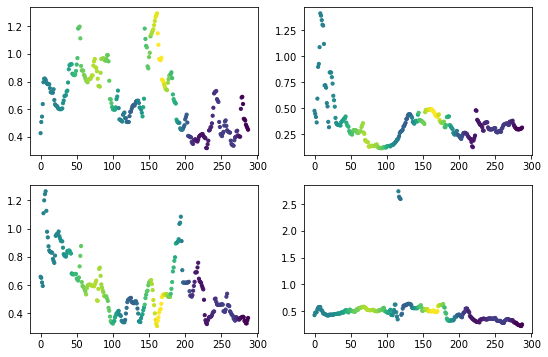

In [232]:
cam = GradCAM(model,4)
plt.figure(figsize=(9,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    cam.plot(x_test[i:i+1])

In [292]:
ds = 0.05
val_range = np.arange(0,2+ds,ds)
total_score = np.zeros((288,len(val_range),3))
for d in range(288):
    dummy = np.zeros((len(val_range),288,1))
    dummy[:,d,0] = val_range
    pred = model.predict(dummy)
    total_score[d] = pred

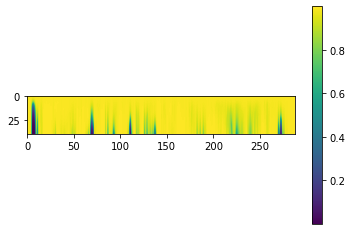

In [296]:
plt.imshow(total_score[:,:,0].T)
plt.colorbar()